In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import numpy as np
import argparse
import torch
import sys
import importlib as ipb
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_mean(result_dict, stop_epoch, return_full=False):
    # Stop_epoch: determine when to stop computing the values.
    full_res = [np.array(i)[:stop_epoch] for i in result_dict.values()]
    if return_full:
        full_mean = np.round(100*np.mean(full_res, axis=0), 2)
        full_std = np.round(100*np.std(full_res, axis=0), 2)
        return [full_mean, full_std]  # For plot
    else:
        idx = [np.argmax(i[:, 1])
               for i in full_res]  # Collect idx at which valid is highest
        vals = [i[j] for i, j in zip(full_res, idx)]
        means = np.round(100*np.mean(vals, axis=0), decimals=2)
        stds = np.round(100*np.std(vals, axis=0), decimals=2)
        return [means, stds]  # For table

In [3]:
def plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC=False, change_ratio=False, ratio_mult=1, full_epoch=True, return_early=False):
        '''
            full_epoch: Decides if we plot the entire trajectory or just the initial segments
        '''
        result_dict = json.load(open(f'{key_SVI}.json'))
        key_SVI_dict = 'SVI-SGD' if 'warmstart' not in key_SVI else 'SVI_warmstart-SGD'
        key_SVI_Adam_dict = 'SVI-Adam' if 'warmstart' not in key_SVI_Adam else 'SVI_warmstart-Adam'
        results_over_runs_SVI = result_dict[key_SVI_dict][0]
        # result_dict = json.load(open(f'{key_SVI_Adam}.json'))
        # results_over_runs_SVI_Adam = result_dict[key_SVI_Adam_dict][0]
        result_dict = json.load(open(f'{key_SGD}.json'))
        results_over_runs_SGD = result_dict['SGD'][0]
        # result_dict = json.load(open(f'{key_Adam}.json'))
        # results_over_runs_Adam = result_dict['Adam'][0]
        stop_epoch = len(results_over_runs_SVI[f'lr={lr0[1:]}@Run1']) if full_epoch else 100
        if return_early:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=False)
            # results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=False)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=False)
            # results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=False)
            # NOTE, they include train test mean and std.
            # res_mean = np.concatenate(
            #     [val[0] for val in [results_SVI, results_SGD, results_SVI_Adam, results_Adam]])
            # res_std = np.concatenate(
            #     [val[1] for val in [results_SVI, results_SGD, results_SVI_Adam,  results_Adam]])
            res_mean = np.concatenate(
                [val[0] for val in [results_SVI, results_SGD]])
            res_std = np.concatenate(
                [val[1] for val in [results_SVI, results_SGD]])
            return [res_mean, res_std]
        else:
            results_SVI = get_mean(results_over_runs_SVI, stop_epoch, return_full=True)
            # results_SVI_Adam = get_mean(results_over_runs_SVI_Adam, stop_epoch, return_full=True)
            results_SGD = get_mean(results_over_runs_SGD, stop_epoch, return_full=True)
            # results_Adam = get_mean(results_over_runs_Adam, stop_epoch, return_full=True)
            # res_orig = [results_over_runs_SVI, results_over_runs_SGD,
            #             results_over_runs_SVI_Adam, results_over_runs_Adam]
            res_orig = [results_over_runs_SVI, results_over_runs_SGD]
            mtd_dict = {0: 'SVI-SGD', 1: 'SGD', 2: 'SVI-Adam', 3: 'Adam'}
            mtd_dict = {0: 'SVI', 1: 'SGD'}
            fig, ax = plt.subplots(1, len(mtd_dict), figsize=(9*len(mtd_dict), 4), sharey=True, sharex=True)
            type_dict = {0: 'Train', 1: 'Valid', 2: 'Test'}
            print(f'LR={lr0[1:]} up to {stop_epoch} epochs')
            # for i, result in enumerate([results_SVI, results_SGD, results_SVI_Adam, results_Adam]):
            for i, result in enumerate([results_SVI, results_SGD]):
                res_mean, res_std = result
                res_mean_final, res_std_final = get_mean(res_orig[i], stop_epoch, return_full=False)
                for j in range(3):  # Train, Valid, Test
                    ax[i].plot(res_mean[:, j], label=type_dict[j])
                    ax[i].fill_between(np.arange(stop_epoch), res_mean[:, j]-res_std[:, j],
                                       res_mean[:, j]+res_std[:, j], alpha=0.3)
                    if j == 0:
                        print(mtd_dict[i])
                    ax[i].set_title(
                        f'{mtd_dict[i]} Train {res_mean_final[0]}'+r'$\pm$'+f'{res_std_final[0]}'+f', \n Valid: {res_mean_final[1]}'+r'$\pm$'+f'{res_std_final[1]}'+f', Test: {res_mean_final[2]}'+r'$\pm$'+f'{res_std_final[2]}',
                        fontsize = 30)
                    ax[i].legend(loc='lower right', ncol=3, fontsize=24)
                    ax[i].grid(True)
                    ax[i].tick_params(axis='both', which='major', labelsize=22)
            fig.tight_layout()
            full_e = '' if full_epoch else '_sub_epoch'
            fc_use = '-FC' if FC else ''
            c_ratio = '-change_ratio' if change_ratio else ''
            ratio = ratio_mult if ratio_mult < 1 else ''
            warm_or_not = '_warmstart' if 'warmstart' in key_SVI else ''
            fig.savefig(f'SVI_only{warm_or_not}_SGD_Adam_vs_SGD_Adam{model_architect}{lr0}LR{full_e}{fc_use}{c_ratio}{ratio}_correct_split.png',
                        dpi=100, bbox_inches='tight', pad_inches=0)
            plt.show()

## Table & Plot of comparisons

### 128 nodes, 0.001 lr (warm start by default)

In [4]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-128nodes'
lrs=['-0.001']
warmstart = True
# NOTE: first 12 includes mean values and the rest for std.
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
mtds = ['SVI-SGD', 'SGD']
full_result = np.zeros((len(lrs), len(mtds)*6))
full_result_sub = np.zeros((len(lrs), len(mtds)*6))
for i, lr0 in enumerate(lrs):
    if warmstart:
        key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
        key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    else:
        key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
        key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), len(mtds)*3), dtype=object)
full_tmp_sub = np.zeros((len(lrs), len(mtds)*3), dtype=object)
for i in range(len(lrs)):
    for j in range(len(mtds)*3):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, len(mtds)*3+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, len(mtds)*3+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
           SVI-SGD                                      SGD                \
             Train         Valid          Test        Train         Valid   
0.001  64.8 (0.05)  67.03 (0.01)  67.29 (0.13)  64.8 (0.05)  67.07 (0.12)   

                     
               Test  
0.001  67.44 (0.02)  
\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} \\
{} &        Train &         Valid &          Test &        Train &         Valid &          Test \\
\midrule
0.001 &  64.8 (0.05) &  67.03 (0.01) &  67.29 (0.13) &  64.8 (0.05) &  67.07 (0.12) &  67.44 (0.02) \\
\bottomrule
\end{tabular}

##########################
Result over initial epochs
            SVI-SGD                                       SGD              \
              Train         Valid          Test         Train       Valid   
0.001  52.12 (0.87)  54.84 (0.73)  54.93 (0.79)  48.43 (2.56)  51.4 (2.4)   

                     
               Test  
0.001  51.52 (

/tmp/ipykernel_17604/1490918402.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_17604/1490918402.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 1000 epochs
SVI
SGD


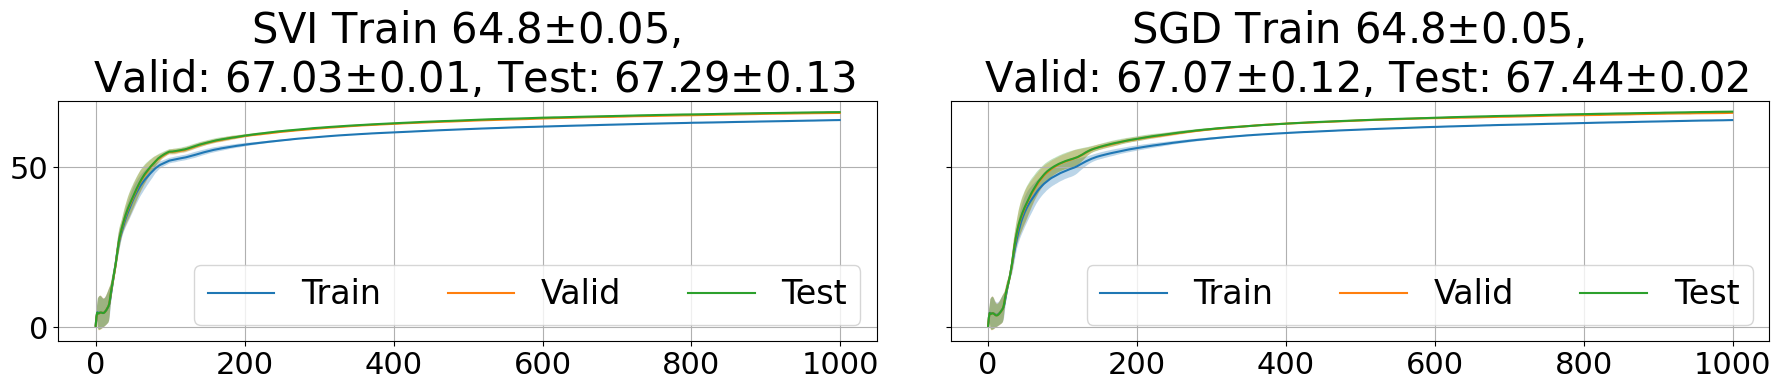

LR=0.001 up to 100 epochs
SVI
SGD


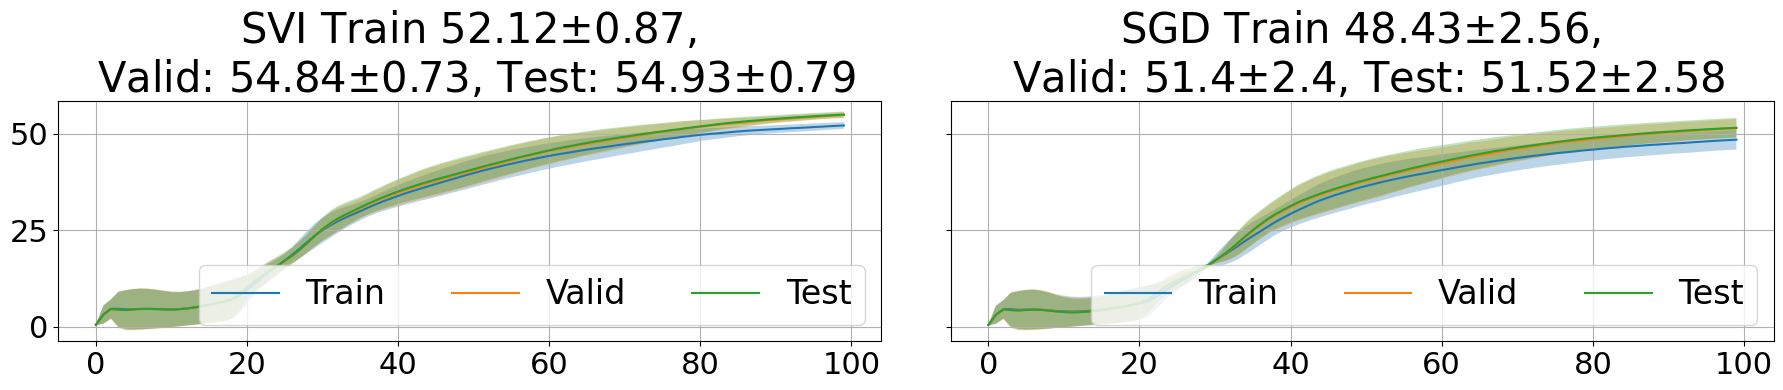

In [5]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
FC = False
change_ratio = False
for lr0 in lrs:
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

### 256 nodes, 0.001 lr (warm start by default)

In [6]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-256nodes'
lrs=['-0.001']
warmstart = True
# NOTE: first 12 includes mean values and the rest for std.
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
mtds = ['SVI-SGD', 'SGD']
full_result = np.zeros((len(lrs), len(mtds)*6))
full_result_sub = np.zeros((len(lrs), len(mtds)*6))
for i, lr0 in enumerate(lrs):
    if warmstart:
        key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
        key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    else:
        key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
        key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), len(mtds)*3), dtype=object)
full_tmp_sub = np.zeros((len(lrs), len(mtds)*3), dtype=object)
for i in range(len(lrs)):
    for j in range(len(mtds)*3):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, len(mtds)*3+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, len(mtds)*3+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
           SVI-SGD                                      SGD                \
             Train         Valid          Test        Train         Valid   
0.001  67.76 (0.1)  69.46 (0.08)  69.69 (0.01)  68.01 (0.1)  69.53 (0.04)   

                     
               Test  
0.001  69.75 (0.03)  
\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} \\
{} &        Train &         Valid &          Test &        Train &         Valid &          Test \\
\midrule
0.001 &  67.76 (0.1) &  69.46 (0.08) &  69.69 (0.01) &  68.01 (0.1) &  69.53 (0.04) &  69.75 (0.03) \\
\bottomrule
\end{tabular}

##########################
Result over initial epochs
            SVI-SGD                                       SGD                \
              Train         Valid          Test         Train         Valid   
0.001  57.34 (0.38)  59.97 (0.47)  59.95 (0.57)  54.63 (0.94)  57.53 (1.08)   

                     
               Test  
0.001  5

/tmp/ipykernel_17604/4161640700.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_17604/4161640700.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 1000 epochs
SVI
SGD


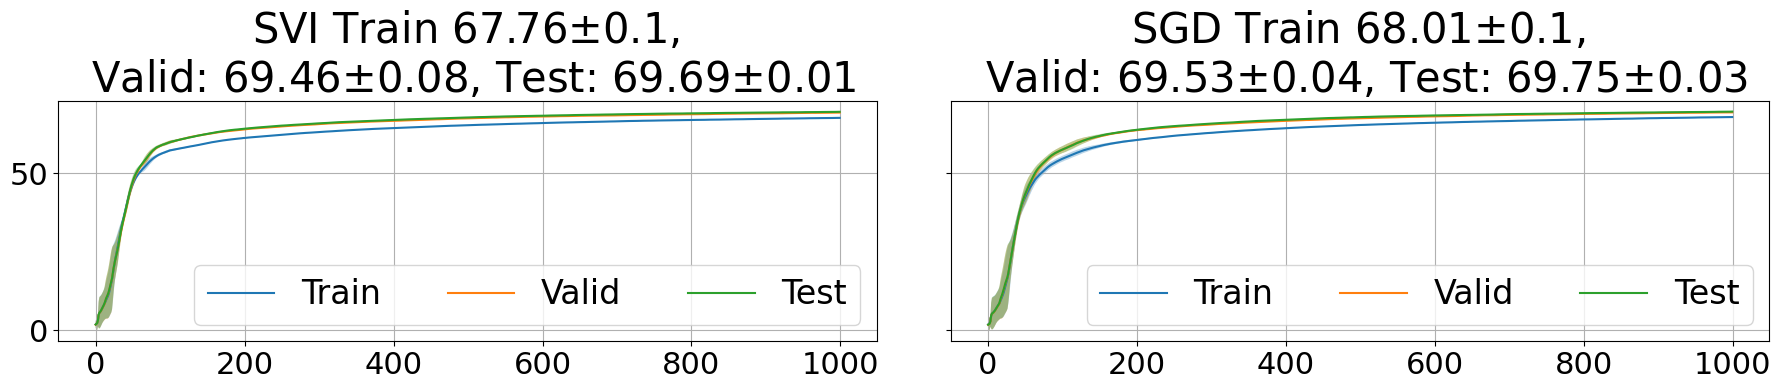

LR=0.001 up to 100 epochs
SVI
SGD


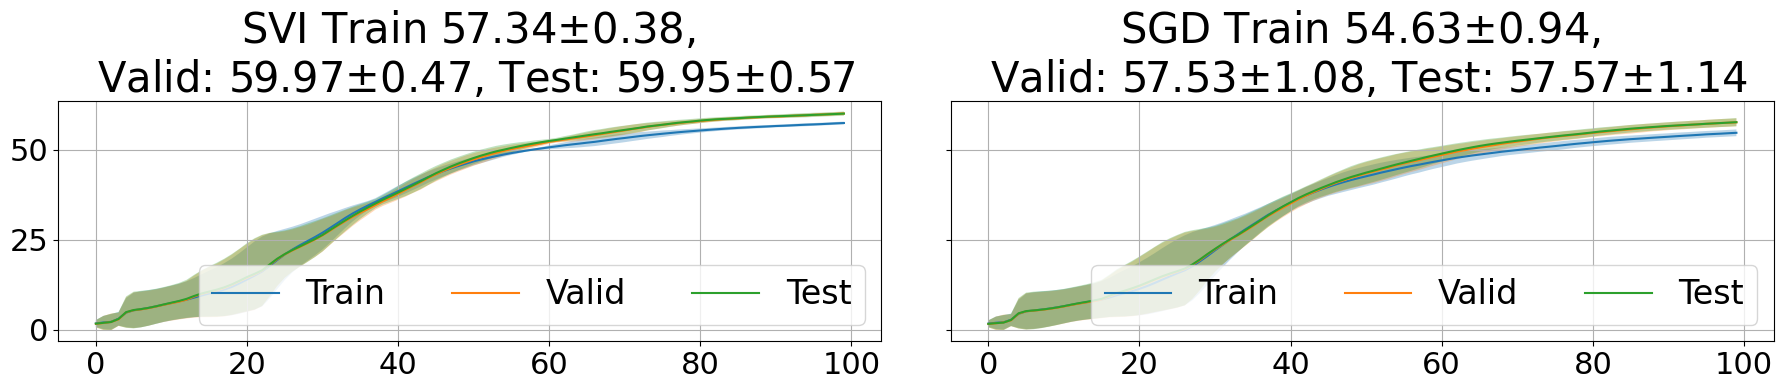

In [7]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
FC = False
change_ratio = False
for lr0 in lrs:
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)

### 512 nodes, 0.001 lr (warm start by default)

In [12]:
# First make summary tables over LR.
# See Table 1 of Rebuttal
model_architect = '-4layers-512nodes'
lrs=['-0.001']
warmstart = True
# NOTE: first 12 includes mean values and the rest for std.
mtds = ['SVI-SGD', 'SGD', 'SVI-Adam', 'Adam']
mtds = ['SVI-SGD', 'SGD']
full_result = np.zeros((len(lrs), len(mtds)*6))
full_result_sub = np.zeros((len(lrs), len(mtds)*6))
for i, lr0 in enumerate(lrs):
    if warmstart:
        key_SVI = f'SVI_warmstart-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
        key_SVI_Adam = f'SVI_warmstart-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    else:
        key_SVI = f'SVI-SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
        key_SVI_Adam = f'SVI-Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only'
    key_SGD = f'SGD{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    key_Adam = f'Adam{model_architect}{lr0}LR_correct_split_loss_together_SVI_only_shuffle_1000'
    full_result[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                        model_architect, lr0, full_epoch=True, return_early=True))
    full_result_sub[i] = np.concatenate(plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam,
                                                            model_architect, lr0, full_epoch=False, return_early=True))
full_tmp = np.zeros((len(lrs), len(mtds)*3), dtype=object)
full_tmp_sub = np.zeros((len(lrs), len(mtds)*3), dtype=object)
for i in range(len(lrs)):
    for j in range(len(mtds)*3):
        full_tmp[i, j] = f'{full_result[i, j]} ({full_result[i, len(mtds)*3+j]})'
        full_tmp_sub[i, j] = f'{full_result_sub[i, j]} ({full_result_sub[i, len(mtds)*3+j]})'
full_result = full_tmp
full_result_sub = full_tmp_sub
type = ['Train', 'Valid', 'Test']
tuples = list(zip(*[np.repeat(mtds, 3), np.tile(type, 4)]))
index = pd.MultiIndex.from_tuples(tuples)
lr_names = [lr[1:] for lr in lrs]
full_result = pd.DataFrame(full_result, index=lr_names, columns=index)  # Index are LRs
print('Result over all epochs')
print(full_result)
print(full_result.to_latex())
print('##########################')
print('Result over initial epochs')
full_result_sub = pd.DataFrame(full_result_sub, index=lr_names, columns=index)  # Index are LRs
print(full_result_sub)
print(full_result_sub.to_latex())

Result over all epochs
            SVI-SGD                                       SGD                \
              Train         Valid          Test         Train         Valid   
0.001  70.35 (0.07)  70.64 (0.06)  70.84 (0.02)  70.66 (0.05)  70.64 (0.06)   

                    
              Test  
0.001  70.8 (0.06)  
\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{3}{l}{SVI-SGD} & \multicolumn{3}{l}{SGD} \\
{} &         Train &         Valid &          Test &         Train &         Valid &         Test \\
\midrule
0.001 &  70.35 (0.07) &  70.64 (0.06) &  70.84 (0.02) &  70.66 (0.05) &  70.64 (0.06) &  70.8 (0.06) \\
\bottomrule
\end{tabular}

##########################
Result over initial epochs
            SVI-SGD                                       SGD               \
              Train         Valid          Test         Train        Valid   
0.001  61.43 (0.18)  64.38 (0.17)  64.52 (0.27)  60.29 (0.17)  63.5 (0.23)   

                    
              Test  
0.001  6

/tmp/ipykernel_17604/2327167583.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result.to_latex())
/tmp/ipykernel_17604/2327167583.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(full_result_sub.to_latex())


LR=0.001 up to 1000 epochs
SVI
SGD


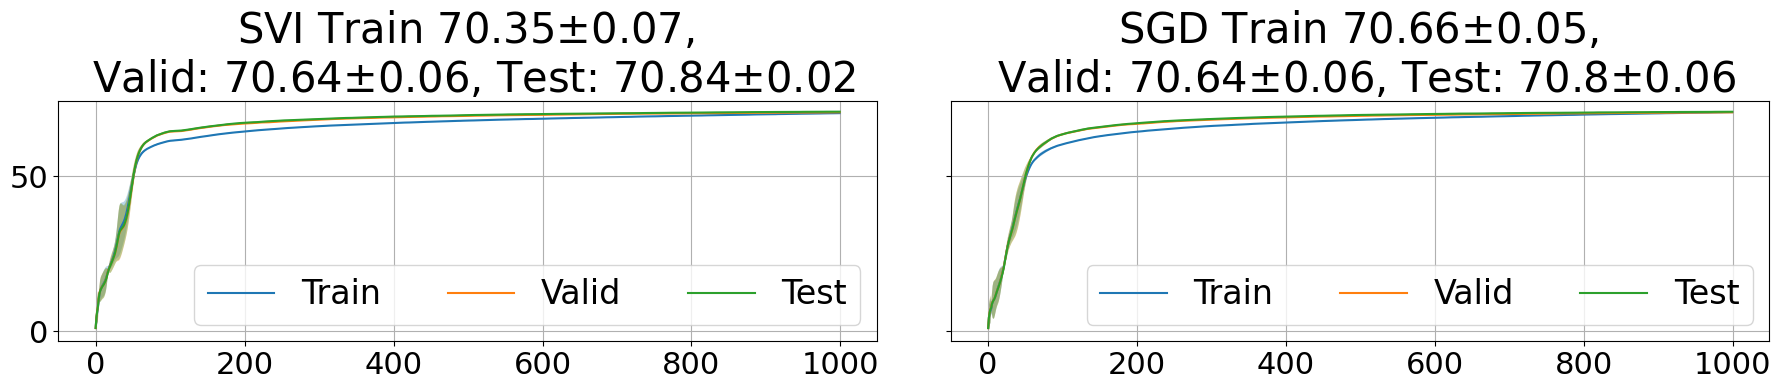

LR=0.001 up to 100 epochs
SVI
SGD


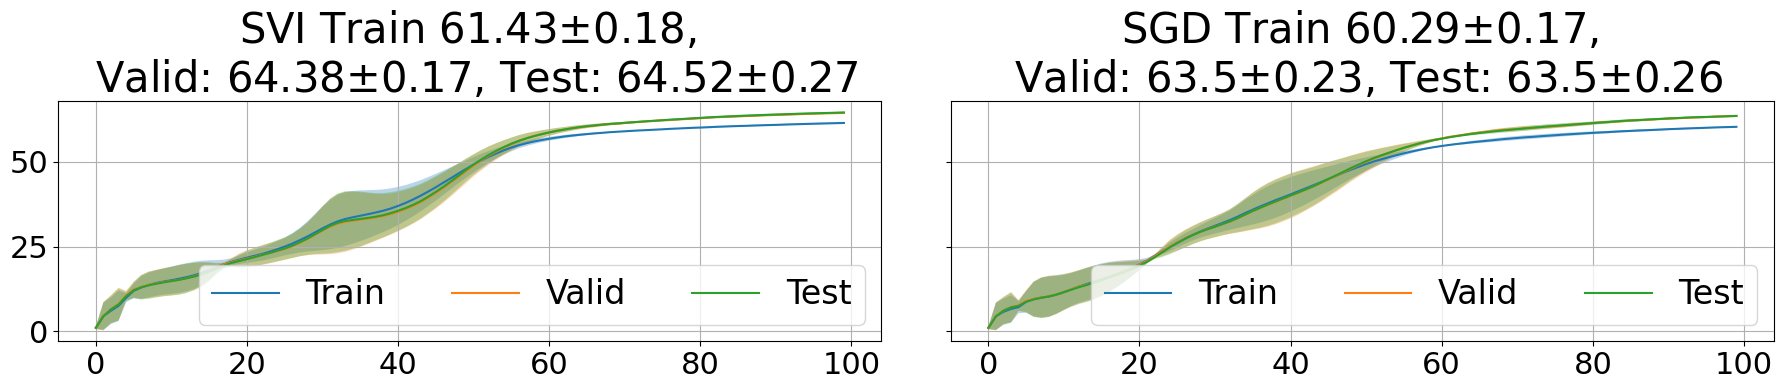

In [13]:
# Then make detailed plots. ONLY at non-FC model (FC=False) and no change in train size (change_ratio=False). 
# See Figure 1 of rebuttal
FC = False
change_ratio = False
for lr0 in lrs:
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=True)
    plot_correct_split(key_SVI, key_SVI_Adam, key_SGD, key_Adam, model_architect, lr0, FC, change_ratio,full_epoch=False)